# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate


### Files

#### Inputs

In [2]:
input_gisaid = 'data/raw/northamerica_metadata.xls'

#### Outputs



In [3]:
export_augur = 'data/clean/northamerica_metadata_clean.tsv'

### Parameters

## Load raw data from GISAID

In [4]:
meta_raw = pd.DataFrame(pd.read_excel(input_gisaid))
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_9880015,EPI1985927|Seq1 [organism=Influenza A virus](A...,EPI1985928|Seq2 [organism=Influenza A virus](A...,EPI1985926|Seq3 [organism=Influenza A virus](A...,EPI1985930|Seq4 [organism=Influenza A virus](A...,EPI1985923|Seq5 [organism=Influenza A virus](A...,EPI1985929|Seq6 [organism=Influenza A virus](A...,EPI1985925|Seq7 [organism=Influenza A virus](A...,EPI1985924|Seq8 [organism=Influenza A virus](A...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_9880019,EPI1985935|Seq1_A/mallard/North Carolina/AH018...,EPI1985936|Seq2_A/mallard/North Carolina/AH018...,EPI1985934|Seq3_A/mallard/North Carolina/AH018...,EPI1985938|Seq4_A/mallard/North Carolina/AH018...,EPI1985931|Seq5_A/mallard/North Carolina/AH018...,EPI1985937|Seq6_A/mallard/North Carolina/AH018...,EPI1985933|Seq7_A/mallard/North Carolina/AH018...,EPI1985932|Seq8_A/mallard/North Carolina/AH018...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_9880021,EPI1985943|Seq1_A/northern pintail/North Carol...,EPI1985944|Seq2_A/northern pintail/North Carol...,EPI1985942|Seq3_A/northern pintail/North Carol...,EPI1985946|Seq4_A/northern pintail/North Carol...,EPI1985939|Seq5_A/northern pintail/North Carol...,EPI1985945|Seq6_A/northern pintail/North Carol...,EPI1985941|Seq7_A/northern pintail/North Carol...,EPI1985940|Seq8_A/northern pintail/North Carol...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_9880151,EPI1985951|Seq1_A/gadwall/North Carolina/AH018...,EPI1985952|Seq2_A/gadwall/North Carolina/AH018...,EPI1985950|Seq3_A/gadwall/North Carolina/AH018...,EPI1985954|Seq4_A/gadwall/North Carolina/AH018...,EPI1985947|Seq5_A/gadwall/North Carolina/AH018...,EPI1985953|Seq6_A/gadwall/North Carolina/AH018...,EPI1985949|Seq7_A/gadwall/North Carolina/AH018...,EPI1985948|Seq8_A/gadwall/North Carolina/AH018...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_9880152,EPI1985959|Seq1_A/northern shoveler/North Caro...,EPI1985960|Seq2_A/northern shoveler/North Caro...,EPI1985958|Seq3_A/northern shoveler/North Caro...,EPI1985962|Seq4_A/northern shoveler/North Caro...,EPI1985955|Seq5_A/northern shoveler/North Caro...,EPI1985961|Seq6_A/northern shoveler/North Caro...,EPI1985957|Seq7_A/northern shoveler/North Caro...,EPI1985956|Seq8_A/northern shoveler/North Caro...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [5]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [6]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [7]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'avian_flu'

## Parse metadata

### Parse country

In [8]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [9]:
meta_working['host'].unique()

array(['Avian', 'Turkey', 'Chicken', 'Pheasant', 'Mallard', 'Duck',
       'Goose', 'Gallus gallus domesticus', 'Domestic goose', 'Ostrich',
       'Other mammals', 'Meleagris gallopavo', 'Seal', 'mammals',
       'Haliaeetus leucocephalus', 'Anser caerulescens', 'Sterna hirundo',
       'Somateria mollissima', 'Anser rossii', 'Lophodytes cucullatus',
       'Aythya affinis', 'Buteo jamaicensis', 'Gallus gallus',
       'Guineafowl', 'Wild bird', 'Branta canadensis', 'Other avian',
       'Leucophaeus', 'Crow', 'Larus smithsonianus', 'Calidris alba',
       'Falco peregrinus', 'Larus marinus', 'Gull', 'Cormorant',
       'Buteo lineatus', 'Host', 'Wild birds', 'Eagle', 'Swan',
       'Larus argentatus', 'Falcon', 'Human', 'Felis catus',
       'Wild waterfowl', 'Anseriformes sp.', 'Larus delawarensis',
       'Cairina moschata', 'Larus', 'Mink', 'Animal'], dtype=object)

### Parse host

In [10]:
# Rename raw host column:
meta_working = meta_working.rename(
    columns = {
        'host': 'host_raw',
    }
)

# Empirical lists of avian and human values
hosts_avian = ['Avian', 'Turkey', 'Chicken',
               'Pheasant', 'Mallard', 'Duck',
               'Goose', 'Gallus gallus domesticus',
               'Domestic goose', 'Ostrich', 'Meleagris gallopavo', 
                'Haliaeetus leucocephalus', 'Anser caerulescens',
                'Sterna hirundo', 'Somateria mollissima', 'Anser rossii',
                'Lophodytes cucullatus', 'Aythya affinis',
                'Buteo jamaicensis', 'Gallus gallus', 'Guineafowl',
                'Wild bird', 'Branta canadensis', 'Other avian', 
                'Leucophaeus', 'Crow', 'Larus smithsonianus',
                'Calidris alba', 'Falco peregrinus', 'Larus marinus',
                'Gull', 'Cormorant', 'Buteo lineatus', 'Wild birds',
                'Eagle', 'Swan', 'Larus argentatus', 'Falcon',
                'Wild waterfowl', 'Anseriformes sp.', 'Larus delawarensis',
                'Cairina moschata', 'Larus']
hosts_mammal = ['Other mammals', 'Seal', 'mammals', 'Felis catus', 'Mink',]

def label_host(val):
    if val in hosts_avian:
        return 'Avian'
    elif val in hosts_mammal:
        return 'Mammal'
    elif val == 'Human':
        return 'Human'
    else:
        return np.nan

meta_working['host'] = (
    meta_working['host_raw']
    .apply(label_host))

In [11]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host_raw,submitting_lab,originating_lab,virus,region,country,host
0,A/American wigeon/North Carolina/AH0182517/2022,2022-01-08,EPI_ISL_9880015,North America / United States / North Carolina...,Avian,National Veterinary Services Laboratories - USDA,USDA-NWRC Wildlife Services,avian_flu,North America,United States,Avian
1,A/mallard/North Carolina/AH0182886/2022,2022-01-08,EPI_ISL_9880019,North America / United States / North Carolina...,Avian,National Veterinary Services Laboratories - USDA,USDA-NWRC Wildlife Services,avian_flu,North America,United States,Avian
2,A/northern pintail/North Carolina/AH0182892/2022,2022-01-08,EPI_ISL_9880021,North America / United States / North Carolina...,Avian,National Veterinary Services Laboratories - USDA,USDA-NWRC Wildlife Services,avian_flu,North America,United States,Avian
3,A/gadwall/North Carolina/AH0182894/2022,2022-01-08,EPI_ISL_9880151,North America / United States / North Carolina...,Avian,National Veterinary Services Laboratories - USDA,USDA-NWRC Wildlife Services,avian_flu,North America,United States,Avian
4,A/northern shoveler/North Carolina/AH0182913/2022,2022-01-08,EPI_ISL_9880152,North America / United States / North Carolina...,Avian,National Veterinary Services Laboratories - USDA,USDA-NWRC Wildlife Services,avian_flu,North America,United States,Avian
5,A/American wigeon/North Carolina/AH0182954/2022,2022-01-08,EPI_ISL_9880153,North America / United States / North Carolina...,Avian,National Veterinary Services Laboratories - USDA,USDA-NWRC Wildlife Services,avian_flu,North America,United States,Avian
6,A/chicken/Maryland/22-006578-001-original/2022,2022-03-03,EPI_ISL_11897507,North America / United States / Maryland / Cecil,Avian,National Veterinary Services Laboratories - USDA,National Veterinary Services Laboratories - USDA,avian_flu,North America,United States,Avian
7,A/chicken/Maryland/22-006578-002-original/2022,2022-03-03,EPI_ISL_11897508,North America / United States / Maryland / Cecil,Avian,National Veterinary Services Laboratories - USDA,National Veterinary Services Laboratories - USDA,avian_flu,North America,United States,Avian
8,A/chicken/Missouri/22-006639-001-original/2022,2022-03-03,EPI_ISL_11897667,North America / United States / Missouri / Bates,Avian,National Veterinary Services Laboratories - USDA,National Veterinary Services Laboratories - USDA,avian_flu,North America,United States,Avian
9,A/turkey/South Dakota/22-006792-001-original/2022,2022-03-04,EPI_ISL_11897668,North America / United States / South Dakota /...,Avian,National Veterinary Services Laboratories - USDA,National Veterinary Services Laboratories - USDA,avian_flu,North America,United States,Avian


## Clean dataframe
Clean up values.

Clean strain names.
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [12]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [13]:
meta_working.head(n=20)['strain']

0       A/American_wigeon/North_Carolina/AH0182517/2022
1               A/mallard/North_Carolina/AH0182886/2022
2      A/northern_pintail/North_Carolina/AH0182892/2022
3               A/gadwall/North_Carolina/AH0182894/2022
4     A/northern_shoveler/North_Carolina/AH0182913/2022
5       A/American_wigeon/North_Carolina/AH0182954/2022
6        A/chicken/Maryland/22-006578-001-original/2022
7        A/chicken/Maryland/22-006578-002-original/2022
8        A/chicken/Missouri/22-006639-001-original/2022
9     A/turkey/South_Dakota/22-006792-001-original/2022
10    A/turkey/South_Dakota/22-006792-002-original/2022
11            A/turkey/Iowa/22-006795-001-original/2022
12            A/turkey/Iowa/22-006795-002-original/2022
13        A/turkey/Missouri/22-006944-002-original/2022
14       A/chicken/Delaware/22-006945-001-original/2022
15       A/chicken/Delaware/22-006945-002-original/2022
16       A/chicken/Maryland/22-006948-001-original/2022
17       A/chicken/Maryland/22-007086-001-origin

### Deduplicate strains

In [14]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 3410 records.
	There were 3403 unique records.
	After cleaning, there were 3403 records remaining.


## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [15]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [16]:
meta_clean['strain'].count()

3403

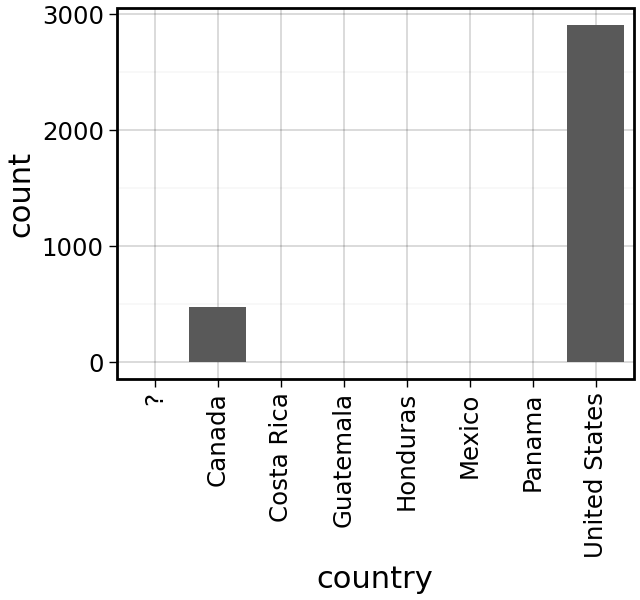

In [17]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(meta_clean['country'].nunique()/2.5,
                            3))
)

seqs_by_country

### List strains by country

In [18]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"\n# {key} (n={len(value)})")
    for v in value:
        print(v)


# Canada (n=480)
A/Fancy_chicken/NL/FAV-0035/2021
A/domestic_goose/NL/FAV-0035-17/2021
A/emu/NL/FAV-0035-12/2021
A/chicken/NL/FAV-0033/2021
A/Chicken/BC/FAV-0346-OS/2022
A/Chicken/BC/FAV-0348-OS/2022
A/Chicken/BC/FAV-0402-OS/2022
A/Chicken/BC/FAV-0369-OS/2022
A/Chicken/BC/FAV-0460-OS/2022
A/Chicken/BC/FAV-0488-OS/2022
A/Bald_Eagle/BC/OTH-33-36/2022_(H5N1)
A/Broiler_Chicken/BC/FAV-0228/2022_(H5N1)
A/Turkey/SK/FAV-0266/2022
A/Snow_Goose/SK/FAV-0216-01/2022
A/Snow_Goose/SK/FAV-0216-02/2022
A/Snow_Goose/SK/FAV-0216-06/2022
A/Bald_Eagle/PEI/FAV-0129-01/2022
A/Bald_Eagle/PEI/FAV-0172/2022
A/Bald_Eagle/ON/FAV-0221-01/2022
A/Bald_eagle/ON/FAV-0221-02/2022
A/Turkey/ON/FAV-0162-144/2022
A/Turkey_Vulture/ON/FAV-0178-01/2022
A/Bald_Eagle/ON/FAV-0178-02/2022
A/Canada_Goose/ON/FAV-0187-01/2022
A/Chicken/ON/FAV-0208-133/2022
A/Chicken/ON/FAV-0208-144/2022
A/Chicken/ON/FAV-0217-05/2022
A/Great_Horned_Owl/AB/FAV-0505-19/2022
A/Great_Horned_Owl/AB/FAV-0505-30/2022
A/Canada_Goose/AB/FAV-0505-31/2022
A/C